# AR5IR RCMIP

Here we perform the AR5IR runs for RCMIP. This notebook shows how the OpenSCM library should 'feel' to the end user. We're not at that point yet and will need a major re-write to get it workable, but this at least shows where we're going.

## Imports

In [147]:
import json
import os.path

import numpy as np
import pandas as pd
import pyam
import tqdm.notebook
from scmdata import df_append, ScmDataFrame

## Models

In [148]:
class AR5IRBase():
    def __init__(self):
        pass

    def run(self, inputs, run_params, outputs=None):
        """
        inputs : scmdata.ScmDataFrame
        
        run_params : dict
        """
        if outputs is not None and outputs != ["Surface Temperature"]:
            print(outputs)
            raise ValueError("{} only calculates Surface Temperature".format(self.name))
    
        co2_concentrations_scmdf = inputs.filter(
            variable="Atmospheric Concentrations|CO2",
            region="World",
            unit="ppm",
        )
        
        scenario = co2_concentrations_scmdf.get_unique_meta("scenario", no_duplicates=True)
        model = co2_concentrations_scmdf.get_unique_meta("model", no_duplicates=True)
        time = co2_concentrations_scmdf["time"]
        
        self.co2_concentrations = co2_concentrations_scmdf.timeseries().values.squeeze()
        non_co2_radiative_forcing_scmdf = inputs.filter(
            variable="Effective Radiative Forcing|Non-CO2",
            region="World",
            unit="W/m\^2",
        )
        if non_co2_radiative_forcing_scmdf.timeseries().empty:
            self.non_co2_radiative_forcing = np.zeros_like(self.co2_concentrations)
            
            non_co2_radiative_forcing_scmdf = self._create_out_scmdf(
                "Effective Radiative Forcing|Non-CO2",
                "W/m^2",
                np.zeros_like(self.co2_concentrations),
                co2_concentrations_scmdf,
            )
        else:
            self.non_co2_radiative_forcing = non_co2_radiative_forcing_scmdf.timeseries().values.squeeze()
            
        assert self.co2_concentrations.shape == self.non_co2_radiative_forcing.shape, (
            "{}, {}".format(self.co2_concentrations.shape, self.non_co2_radiative_forcing.shape)
        )
        for kwarg, value in run_params.items():
            setattr(self, kwarg, value)

        self.calculate_co2_radiative_forcing()
        self.calculate_temperatures()
        
        out_temperatures = self._create_out_scmdf(
            "Surface Air Temperature Change",
            "K",
            self.temperatures,
            co2_concentrations_scmdf,
        )
        
        out_co2_forcing = self._create_out_scmdf(
            "Effective Radiative Forcing|CO2",
            "W/m^2",
            self.co2_radiative_forcing,
            co2_concentrations_scmdf,
        )
        
        out = df_append([
            co2_concentrations_scmdf, 
            non_co2_radiative_forcing_scmdf, 
            out_temperatures, 
            out_co2_forcing,
        ])
        out.set_meta(self.name, "climatemodel")

        return out
    
    def _create_out_scmdf(self, variable, unit, values, base_scmdf):
        out_scmdf = base_scmdf.timeseries()
        out_scmdf.iloc[:, :] = values
        out_scmdf = out_scmdf.reset_index()
        out_scmdf["variable"] = variable
        out_scmdf["unit"] = unit
        
        return ScmDataFrame(out_scmdf)

    def calculate_co2_radiative_forcing(self):
        self.co2_radiative_forcing = (
            self.f2x / np.log(2) * np.log(self.co2_concentrations / self.co2_pi)
        )

In [149]:
class AR5IR2Box(AR5IRBase):
    """
    Quick implementation of AR5IR in a CO2-conc plus non-CO2 ERF driven run mode
    
    Based on:
    F = F2x / ln(2) * ln(C / C_0)
    
    where F2x is RF due to doubling CO2, C is atmospheric conc. of CO2 
    and C_0 is PI conc. of CO2
    
    c_j F = \\Delta T + d_j d \\Delta T / dt 
    
    with j=2 and all terms as in IPCC AR5 WG1 eq. 8.SM.13
    
    Inputs should all be on an annual timestep (no checks are done for
    this...)
    """

    name = "ar5ir2box"

    co2_pi = 278
    f2x = 3.74
    c1 = 0.631
    d1 = 8.4
    c2 = 0.429
    d2 = 409.5

    def calculate_temperatures(self):
        """
        This is a bit fiddly as we have to return mid year values
        """
        c = np.array([self.c1, self.c2])
        d = np.array([self.d1, self.d2])
        temp_perturbations = np.nan * np.zeros((len(self.co2_concentrations) + 1, 2))
        temp_perturbations[0, :] = 0

        factor = 1 - 1 / d
        total_forcing = self.co2_radiative_forcing + self.non_co2_radiative_forcing
        temp = total_forcing[:, np.newaxis] * c / d
        for i in range(1, temp_perturbations.shape[0]):
            temp_perturbations[i, :] = (
                temp_perturbations[i - 1] * factor + temp[i - 1]
            )  # assuming one year timestep

        temp_perturbations_midyear = (
            temp_perturbations[:-1, :] + temp_perturbations[1:, :]
        ) / 2
        self.temperatures = temp_perturbations_midyear.sum(axis=1)

In [150]:
class AR5IR3Box(AR5IRBase):
    """
    Quick implementation of AR5IR with 3 boxes in a CO2-conc plus non-CO2 ERF driven run mode
    
    Based on:
    F = F2x / ln(2) * ln(C / C_0)
    
    where F2x is RF due to doubling CO2, C is atmospheric conc. of CO2 
    and C_0 is PI conc. of CO2
    
    c_j F = \\Delta T + d_j d \\Delta T / dt 
    
    with j=3 and all terms as in IPCC AR5 WG1 eq. 8.SM.13
    
    Inputs should all be on an annual timestep (no checks are done for
    this...)
    """

    name = "ar5ir3box"

    co2_pi = 278
    f2x = 3.74
    c1 = 0.631
    d1 = 8.4
    c2 = 0.429
    d2 = 409.5
    c3 = 0.2
    d3 = 1

    def calculate_temperatures(self):
        """
        This is a bit fiddly as we have to return mid year values
        """
        c = np.array([self.c1, self.c2, self.c3])
        d = np.array([self.d1, self.d2, self.d3])
        temp_perturbations = np.nan * np.zeros((len(self.co2_concentrations) + 1, 3))
        temp_perturbations[0, :] = 0

        factor = 1 - 1 / d
        total_forcing = self.co2_radiative_forcing + self.non_co2_radiative_forcing
        temp = total_forcing[:, np.newaxis] * c / d
        for i in range(1, temp_perturbations.shape[0]):
            temp_perturbations[i, :] = (
                temp_perturbations[i - 1] * factor + temp[i - 1]
            )  # assuming one year timestep

        temp_perturbations_midyear = (
            temp_perturbations[:-1, :] + temp_perturbations[1:, :]
        ) / 2
        self.temperatures = temp_perturbations_midyear.sum(axis=1)

## RCMIP data

In [151]:
RCMIP_TEMP_OBS_FILE = os.path.join(
    "rcmip-observations_observations-priestley-centre_world_surface-air-temperature-change.csv"
)
rcmip_obs = df_append([RCMIP_TEMP_OBS_FILE])

In [152]:
RCMIP_CONCS_FILE = os.path.join(
    "rcmip-concentrations-annual-means-v3-1-0.csv"
)

RCMIP_FORCING_FILE = os.path.join(
    "rcmip-radiative-forcing-annual-means-v3-1-0.csv"
)

In [153]:
rcmip_data = df_append([RCMIP_CONCS_FILE, RCMIP_FORCING_FILE])
rcmip_data.head()

time                                                                                                 1700-01-01 00:00:00  \
model       scenario region variable                                       unit activity_id mip_era                        
unspecified 1pctCO2  World  Atmospheric Concentrations|CH4                 ppb  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|CO2                 ppm  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC125  ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC134a ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC143a ppt  input4MIPs  CMIP6                    NaN   

time                                                                                                 1701-01-01 00:00:00  \
model       scenario region variable                                       unit activity_id mip_era                        
unspecified 1pctCO2  World  Atmospheric Concentrations|CH4                 ppb  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|CO2                 ppm  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC125  ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC134a ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC143a ppt  input4MIPs  CMIP6                    NaN   

time                                                                                                 1702-01-01 00:00:00  \
model       scenario region variable                                       unit activity_id mip_era                        
unspecified 1pctCO2  World  Atmospheric Concentrations|CH4                 ppb  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|CO2                 ppm  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC125  ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC134a ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC143a ppt  input4MIPs  CMIP6                    NaN   

time                                                                                                 1703-01-01 00:00:00  \
model       scenario region variable                                       unit activity_id mip_era                        
unspecified 1pctCO2  World  Atmospheric Concentrations|CH4                 ppb  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|CO2                 ppm  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC125  ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC134a ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC143a ppt  input4MIPs  CMIP6                    NaN   

time                                                                                                 1704-01-01 00:00:00  \
model       scenario region variable                                       unit activity_id mip_era                        
unspecified 1pctCO2  World  Atmospheric Concentrations|CH4                 ppb  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|CO2                 ppm  input4MIPs  CMIP6                    NaN   
                            

In [154]:
co2_conc_0 = (
    rcmip_data.filter(
        variable="Atmospheric Concentrations|CO2",
        region="World",
        scenario="abrupt-2xCO2",
        year=1900,
    ).values.squeeze()
    / 2
)
co2_conc_0

284.31699879964185

Calculate non-CO2 effective radiative forcing.

In [155]:
erf_filter = "Effective Radiative Forcing*"
rcmip_erfs = rcmip_data.filter(
    variable=erf_filter
).timeseries().unstack("variable").stack("time")

rcmip_erfs["Effective Radiative Forcing|Non-CO2"] = (
    rcmip_erfs["Effective Radiative Forcing"] 
    - rcmip_erfs["Effective Radiative Forcing|Anthropogenic|CO2"]
)
rcmip_erfs = rcmip_erfs.unstack("time").stack("variable")
rcmip_data = rcmip_data.filter(variable=erf_filter, keep=False).append(rcmip_erfs)
rcmip_data.head()

time                                                                                                 1700-01-01 00:00:00  \
model       scenario region variable                                       unit activity_id mip_era                        
unspecified 1pctCO2  World  Atmospheric Concentrations|CH4                 ppb  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|CO2                 ppm  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC125  ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC134a ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC143a ppt  input4MIPs  CMIP6                    NaN   

time                                                                                                 1701-01-01 00:00:00  \
model       scenario region variable                                       unit activity_id mip_era                        
unspecified 1pctCO2  World  Atmospheric Concentrations|CH4                 ppb  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|CO2                 ppm  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC125  ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC134a ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC143a ppt  input4MIPs  CMIP6                    NaN   

time                                                                                                 1702-01-01 00:00:00  \
model       scenario region variable                                       unit activity_id mip_era                        
unspecified 1pctCO2  World  Atmospheric Concentrations|CH4                 ppb  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|CO2                 ppm  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC125  ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC134a ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC143a ppt  input4MIPs  CMIP6                    NaN   

time                                                                                                 1703-01-01 00:00:00  \
model       scenario region variable                                       unit activity_id mip_era                        
unspecified 1pctCO2  World  Atmospheric Concentrations|CH4                 ppb  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|CO2                 ppm  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC125  ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC134a ppt  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|F-Gases|HFC|HFC143a ppt  input4MIPs  CMIP6                    NaN   

time                                                                                                 1704-01-01 00:00:00  \
model       scenario region variable                                       unit activity_id mip_era                        
unspecified 1pctCO2  World  Atmospheric Concentrations|CH4                 ppb  input4MIPs  CMIP6                    NaN   
                            Atmospheric Concentrations|CO2                 ppm  input4MIPs  CMIP6                    NaN   
                            

In [156]:
rcmip_data.filter(variable="Effective Radiative Forcing|Non-CO2").head()

time                                                                                                1750-01-01 00:00:00  \
model           scenario   region variable                            unit  activity_id    mip_era                        
unspecified     historical World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.259367   
IMAGE           ssp119     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.259367   
                ssp126     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.259367   
MESSAGE-GLOBIOM ssp245     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.259367   
AIM/CGE         ssp370     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.259367   

time                                                                                                1751-01-01 00:00:00  \
model           scenario   region variable                            unit  activity_id    mip_era                        
unspecified     historical World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.241965   
IMAGE           ssp119     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.241965   
                ssp126     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.241965   
MESSAGE-GLOBIOM ssp245     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.241965   
AIM/CGE         ssp370     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.241965   

time                                                                                                1752-01-01 00:00:00  \
model           scenario   region variable                            unit  activity_id    mip_era                        
unspecified     historical World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.213009   
IMAGE           ssp119     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.213009   
                ssp126     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.213009   
MESSAGE-GLOBIOM ssp245     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.213009   
AIM/CGE         ssp370     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.213009   

time                                                                                                1753-01-01 00:00:00  \
model           scenario   region variable                            unit  activity_id    mip_era                        
unspecified     historical World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.177158   
IMAGE           ssp119     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.177158   
                ssp126     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.177158   
MESSAGE-GLOBIOM ssp245     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.177158   
AIM/CGE         ssp370     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.177158   

time                                                                                                1754-01-01 00:00:00  \
model           scenario   region variable                            unit  activity_id    mip_era                        
unspecified     historical World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.142201   
IMAGE           ssp119     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.142201   
                ssp126     World  Effective Radiative Forcin

## Run

In [157]:
with open("ar5ir2box-cfgs.json", "r") as fh:
    ar5ir2box_cfgs = json.load(fh)
    
ar5ir2box_cfgs[:2]

[{'descr': 'AR5IR (Ch. 8 SM) with ECS=3K and timescale parameters adjusted to give moderate agreement with historical observations.',
  'name': 'ar5ir2box-ECS-3K',
  'parameter_values': {'c1': 0.47, 'c2': 0.33, 'd1': 1.4, 'd2': 100.0}},
 {'descr': 'AR5IR (Ch. 8 SM) calibrated to the idealised CO2-only experiments for the r1i1p1f1 variant of the BCC-CSM2-MR model',
  'name': 'ar5ir2box-CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB',
  'parameter_values': {'c1': 0.490932576984881,
   'c2': 1.4738864993247238,
   'd1': 4.203548024714912,
   'd2': 944.4588051583564}}]

In [158]:
with open("ar5ir3box-cfgs.json", "r") as fh:
    ar5ir3box_cfgs = json.load(fh)
    
ar5ir3box_cfgs[-1]

{'descr': 'AR5IR (Ch. 8 SM) 3 box implementation calibrated to the idealised CO2-only experiments for the r1i1p1f2 variant of the UKESM1-0-LL model',
 'name': 'ar5ir3box-CMIP6-UKESM1-0-LL_r1i1p1f2-CALIB',
 'parameter_values': {'c1': 0.8340230496629214,
  'c2': 0.36163460985095813,
  'c3': 0.7335055979493261,
  'd1': 388.04807164113674,
  'd2': 903.822328225556,
  'd3': 7.04336469051669}}

Runs with default setup.

In [159]:
scenarios_to_run = [
    "abrupt*",
    "1pctCO2*",
    "piControl*",
    "historical",
    "ssp*",
]
runners_cfgs = {
    AR5IR2Box: [c for c in ar5ir2box_cfgs if "ECS-3K" in c["name"]], 
    AR5IR3Box: [c for c in ar5ir3box_cfgs if "ECS-3K" in c["name"]],
}

results_default = []
for model, cfgs in tqdm.notebook.tqdm(runners_cfgs.items(), desc="Model"):
    runner = model()
    runner.co2_pi = co2_conc_0
    startyear=1750
    endyear=2500
    scens_to_run = rcmip_data.filter(
        scenario=scenarios_to_run,
    ).filter(
        mip_era="CMIP6"  # we don't have ERF for CMIP5 scenarios...
    )["scenario"].unique()
    for scenario in tqdm.notebook.tqdm(scens_to_run, desc="scenarios", leave=False):
        run_df = rcmip_data.filter(scenario=scenario, year=range(startyear, endyear+1))
        for cfg in tqdm.notebook.tqdm(cfgs, desc="configs", leave=False):
            pvs = cfg["parameter_values"]
            res_run = runner.run(run_df, pvs)
            res_run.set_meta(cfg["name"], "climatemodel")
            
            boxes = len([k for k in pvs if k.startswith("c")])
            ecs = model.f2x * np.sum([pvs["c{}".format(i)] for i in range(1, boxes+1)])
            res_run.set_meta(ecs, "ECS (K)")
            
            tcr = model.f2x * np.sum(
                [pvs["c{}".format(i)]*(1 - (pvs["d{}".format(i)] / 70) * (1 - np.exp(-70 / pvs["d{}".format(i)]))) for i in range(1, boxes+1)]
            )
            res_run.set_meta(tcr, "TCR (K)")
            
            results_default.append(res_run)
        
            
results_default = df_append(results_default)

Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!


In [160]:
df_append(
    [results_default, rcmip_obs]
).filter(scenario="historical", variable="*Temperature*").head()

time                                                                                                                                    1750-01-01  \
model       scenario   region variable                       unit ECS (K) TCR (K)  activity_id climatemodel                    mip_era               
unspecified historical World  Surface Air Temperature Change K    NaN     NaN      NaN         Observations (Priestley Centre) NaN             NaN   
                                                                  2.992   2.069252 input4MIPs  ar5ir2box-ECS-3K                CMIP6      0.020604   
                                                                          2.192994 input4MIPs  ar5ir3box-ECS-3K                CMIP6      0.014896   

time                                                                                                                                    1751-01-01  \
model       scenario   region variable                       unit ECS (K) TCR (K)  activity_id climatemodel                    mip_era               
unspecified historical World  Surface Air Temperature Change K    NaN     NaN      NaN         Observations (Priestley Centre) NaN             NaN   
                                                                  2.992   2.069252 input4MIPs  ar5ir2box-ECS-3K                CMIP6      0.044421   
                                                                          2.192994 input4MIPs  ar5ir3box-ECS-3K                CMIP6      0.030225   

time                                                                                                                                    1752-01-01  \
model       scenario   region variable                       unit ECS (K) TCR (K)  activity_id climatemodel                    mip_era               
unspecified historical World  Surface Air Temperature Change K    NaN     NaN      NaN         Observations (Priestley Centre) NaN             NaN   
                                                                  2.992   2.069252 input4MIPs  ar5ir2box-ECS-3K                CMIP6      0.043901   
                                                                          2.192994 input4MIPs  ar5ir3box-ECS-3K                CMIP6      0.029091   

time                                                                                                                                    1753-01-01  \
model       scenario   region variable                       unit ECS (K) TCR (K)  activity_id climatemodel                    mip_era               
unspecified historical World  Surface Air Temperature Change K    NaN     NaN      NaN         Observations (Priestley Centre) NaN             NaN   
                                                                  2.992   2.069252 input4MIPs  ar5ir2box-ECS-3K                CMIP6      0.033221   
                                                                          2.192994 input4MIPs  ar5ir3box-ECS-3K                CMIP6      0.024337   

time                                                                                                                                    1754-01-01  \
model       scenario   region variable                       unit ECS (K) TCR (K)  activity_id climatemodel                    mip_era               
unspecified historical World  Surface Air Temperature Change K    NaN     NaN      NaN         Observations (Priestley Centre) NaN             NaN   
                                                                  2.992   2.069252 input4MIPs  ar5ir2box-ECS-3K                CMIP6      0.018547   
                                                                          2.192994 input4MIPs  ar5ir3box-ECS-3K                CMIP6      0.017262   

time                                                                                                                                    1755-01-01  \
model       scenario   region variable                       unit ECS (K) TCR (K)  activity_id 

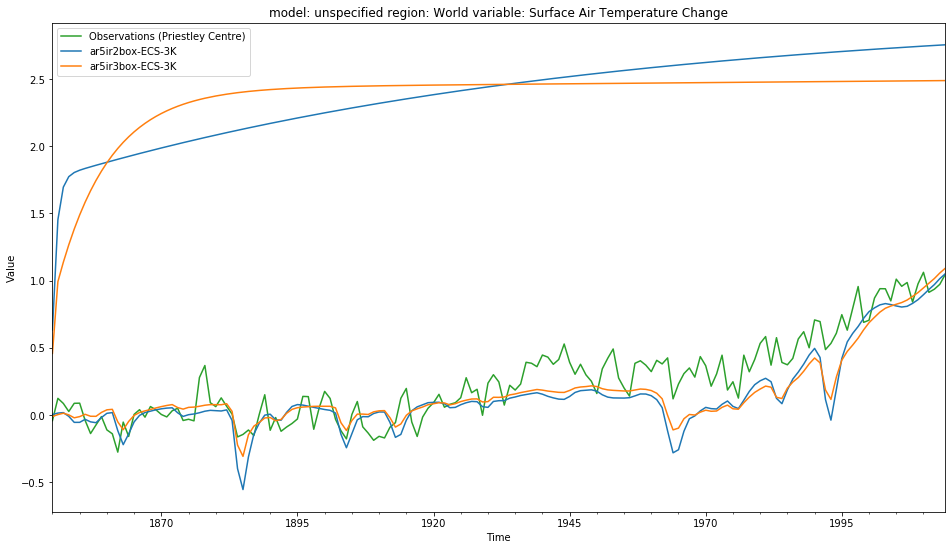

In [161]:
pdf = df_append([results_default, rcmip_obs]).timeseries().reset_index()
ScmDataFrame(pdf.dropna(axis=1)).filter(
    variable="Surface Air Temperature Change", 
    scenario=["historical", "abrupt-2xCO2"]
).line_plot(figsize=(16, 9), color="climatemodel")

In [162]:
scenarios_to_run = [
    "abrupt*",
    "1pctCO2*",
    "piControl*",
]
runners_cfgs = {AR5IR2Box: ar5ir2box_cfgs, AR5IR3Box: ar5ir3box_cfgs}

results = []
for model, cfgs in tqdm.notebook.tqdm(runners_cfgs.items(), desc="Model"):
    runner = model()
    runner.co2_pi = co2_conc_0
    startyear=1750
    endyear=2500
    scens_to_run = rcmip_data.filter(
        scenario=scenarios_to_run,
    ).filter(
        mip_era="CMIP6"  # we don't have ERF for CMIP5 scenarios...
    )["scenario"].unique()
    for scenario in tqdm.notebook.tqdm(scens_to_run, desc="scenarios", leave=False):
        run_df = rcmip_data.filter(scenario=scenario, year=range(startyear, endyear+1))
        for cfg in tqdm.notebook.tqdm(cfgs, desc="configs", leave=False):
            pvs = cfg["parameter_values"]
            res_run = runner.run(run_df, pvs)
            res_run.set_meta(cfg["name"], "climatemodel")
            
            boxes = len([k for k in pvs if k.startswith("c")])
            ecs = model.f2x * np.sum([pvs["c{}".format(i)] for i in range(1, boxes+1)])
            res_run.set_meta(ecs, "ECS (K)")
            
            tcr = model.f2x * np.sum(
                [pvs["c{}".format(i)]*(1 - (pvs["d{}".format(i)] / 70) * (1 - np.exp(-70 / pvs["d{}".format(i)]))) for i in range(1, boxes+1)]
            )
            res_run.set_meta(tcr, "TCR (K)")
            
            results.append(res_run)
        
            
results = df_append(results).append(results_default)

Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


In [163]:
results.filter(scenario="1pctCO2", variable="*Temperature*").timeseries()

time                                                                                                                                                 1850-01-01 00:00:00  \
model       scenario region variable                       unit ECS (K)   TCR (K)  activity_id climatemodel                                 mip_era                        
unspecified 1pctCO2  World  Surface Air Temperature Change K    18.858431 1.256192 input4MIPs  ar5ir3box-CMIP6-GISS-E2-2-G_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                18.984851 1.317942 input4MIPs  ar5ir3box-CMIP6-GISS-E2-1-G_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                13.372198 1.560337 input4MIPs  ar5ir2box-CMIP6-NorESM2-LM_r1i1p1f1-CALIB    CMIP6                    0.0   
                                                                12.483125 1.571337 input4MIPs  ar5ir3box-CMIP6-NorESM2-LM_r1i1p1f1-CALIB    CMIP6                    0.0   
                                                                8.601148  1.632359 input4MIPs  ar5ir3box-CMIP6-NorCPM1_r1i1p1f1-CALIB       CMIP6                    0.0   
                                                                3.703372  1.655601 input4MIPs  ar5ir2box-CMIP6-GISS-E2-2-G_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                7.237664  1.698885 input4MIPs  ar5ir2box-CMIP6-NorCPM1_r1i1p1f1-CALIB       CMIP6                    0.0   
                                                                5.238898  1.732905 input4MIPs  ar5ir2box-CMIP6-GISS-E2-1-G_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                15.298255 1.832597 input4MIPs  ar5ir2box-CMIP6-BCC-ESM1_r1i1p1f1-CALIB      CMIP6                    0.0   
                                                                8.056222  1.837167 input4MIPs  ar5ir3box-CMIP6-BCC-ESM1_r1i1p1f1-CALIB      CMIP6                    0.0   
                                                                6.078483  1.845472 input4MIPs  ar5ir3box-CMIP6-MPI-ESM1-2-HR_r1i1p1f1-CALIB CMIP6                    0.0   
                                                                8.018313  1.846440 input4MIPs  ar5ir2box-CMIP6-MPI-ESM1-2-HR_r1i1p1f1-CALIB CMIP6                    0.0   
                                                                16.676179 1.906268 input4MIPs  ar5ir2box-CMIP6-GISS-E2-1-H_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                8.054546  1.909745 input4MIPs  ar5ir3box-CMIP6-GISS-E2-1-H_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                7.777264  1.915176 input4MIPs  ar5ir3box-CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                7.348423  1.925152 input4MIPs  ar5ir2box-CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                2.992000  2.069252 input4MIPs  ar5ir2box-ECS-3K                             CMIP6                    0.0   
                                                                          2.192994 input4MIPs  ar5ir3box-ECS-3K                             CMIP6                    0.0   
                                                                4.638333  2.223792 input4MIPs  ar5ir2box-CMIP6-CESM2-WACCM_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                8.218950  2.236229 input4MIPs  ar5ir2box-CMIP6-CNRM-ESM2-1_r1i1p1f2-CALIB   CMIP6                    0.0   
                                                                12.178150 2.236674 input4MIPs  ar5ir3box-CMIP6-CNRM-ESM2-1_r1i1p1f2-CALIB   CMIP6                    0.0   
                                            

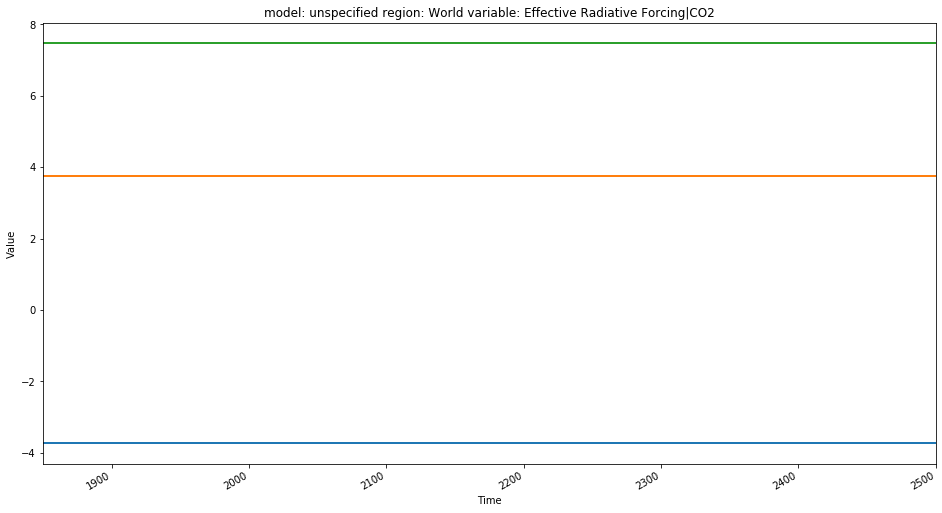

In [164]:
ax = results.filter(scenario="abrupt-*").filter(variable="*Forcing*|CO2").line_plot(
    figsize=(16, 9), linestyle="climatemodel", color="scenario", legend=False
)

(-4, 15)

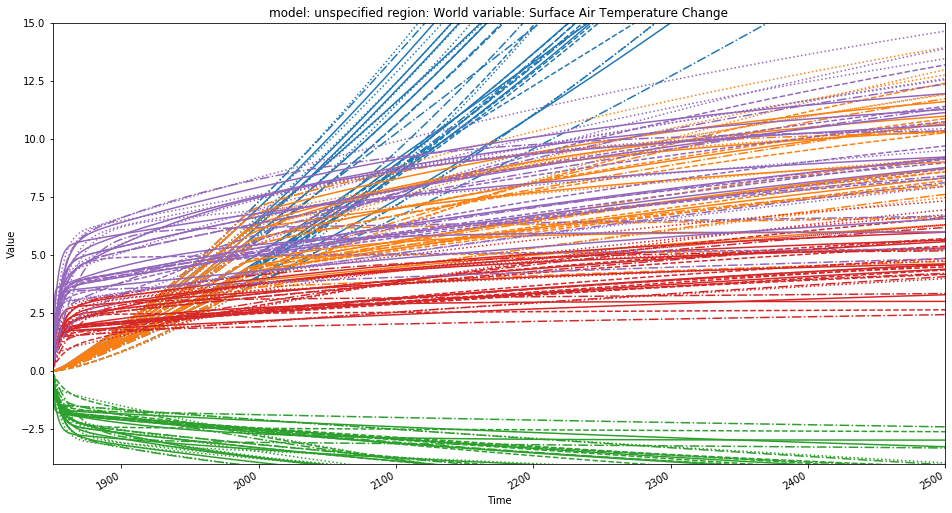

In [165]:
ax = results.filter(
    scenario=["ssp*", "historical", "piControl"], keep=False
).filter(variable="*Temperature*").line_plot(
    figsize=(16, 9), linestyle="climatemodel", color="scenario", legend=False
)
ax.set_ylim([-4, 15])

(-4, 15)

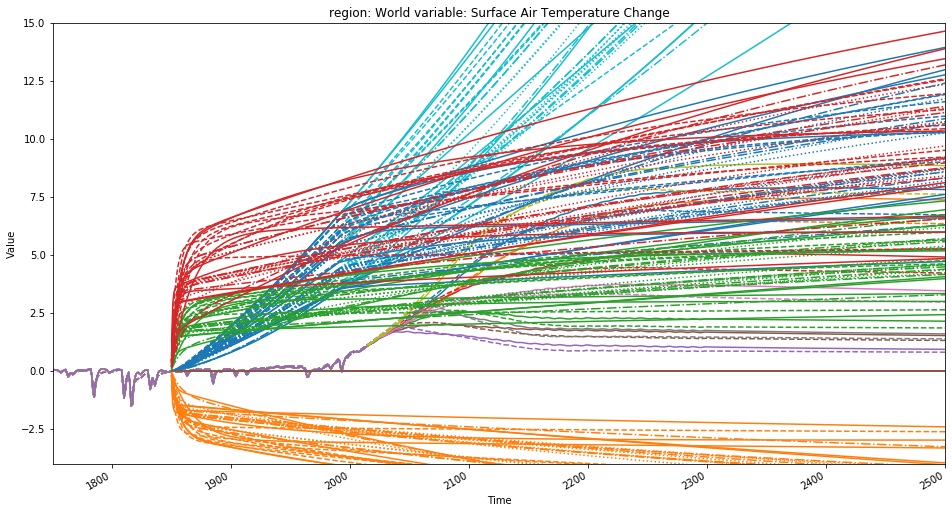

In [166]:
ax = results.filter(variable="*Temperature*").line_plot(
    figsize=(16, 9), linestyle="climatemodel", color="scenario", legend=False
)
ax.set_ylim([-4, 15])

In [167]:
save_scmdf = results.timeseries().unstack("variable").stack("time")
save_scmdf["Effective Radiative Forcing"] = (
    save_scmdf["Effective Radiative Forcing|CO2"]
    + save_scmdf["Effective Radiative Forcing|Non-CO2"]
)
save_scmdf = save_scmdf.unstack("time").stack("variable")

save_scmdf = save_scmdf.reset_index()

def rename_vars(inv):
    if inv == "Effective Radiative Forcing|CO2":
        return "Effective Radiative Forcing|Anthropogenic|CO2"
    
    return inv

save_scmdf["variable"] = save_scmdf["variable"].apply(rename_vars)
save_scmdf = ScmDataFrame(save_scmdf).filter(variable="*Non-CO2", keep=False)
save_scmdf = save_scmdf.timeseries()
save_scmdf.columns = save_scmdf.columns.map(lambda x: x.year)
save_scmdf = pyam.IamDataFrame(save_scmdf)
save_scmdf.to_csv("ar5ir-rcmip-phase-1-results.csv")

In [168]:
save_scmdf["variable"].unique()

array(['Atmospheric Concentrations|CO2',
       'Effective Radiative Forcing|Anthropogenic|CO2',
       'Surface Air Temperature Change', 'Effective Radiative Forcing'],
      dtype=object)

In [169]:
save_scmdf.head(1)

,model,scenario,region,variable,unit,year,climatemodel,mip_era,tcr (k),activity_id,ecs (k),value
0,AIM,ssp370,World,Atmospheric Concentrations|CO2,ppm,1750,ar5ir2box-ECS-3K,CMIP6,2.069252,input4MIPs,2.992,277.147003


In [170]:
desc = save_scmdf[["climatemodel", "ecs (k)", "tcr (k)"]].drop_duplicates()
desc["name"] = desc["climatemodel"].apply(lambda x: x[:5])
desc["version"] = desc["climatemodel"].apply(lambda x: x[5:9])
desc["config"] = desc["climatemodel"].apply(lambda x: "-".join(x.split("-")[1:]))

desc.to_csv("ar5ir-rcmip-model-desc.csv")
desc

,climatemodel,ecs (k),tcr (k),name,version,config
0,ar5ir2box-ECS-3K,2.992000,2.069252,ar5ir,2box,ECS-3K
1,ar5ir3box-ECS-3K,2.992000,2.192994,ar5ir,3box,ECS-3K
40554,ar5ir2box-CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB,7.348423,1.925152,ar5ir,2box,CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB
40555,ar5ir2box-CMIP6-BCC-ESM1_r1i1p1f1-CALIB,15.298255,1.832597,ar5ir,2box,CMIP6-BCC-ESM1_r1i1p1f1-CALIB
40556,ar5ir2box-CMIP6-CESM2-WACCM_r1i1p1f1-CALIB,4.638333,2.223792,ar5ir,2box,CMIP6-CESM2-WACCM_r1i1p1f1-CALIB
40557,ar5ir2box-CMIP6-CESM2_r1i1p1f1-CALIB,5.397971,2.379054,ar5ir,2box,CMIP6-CESM2_r1i1p1f1-CALIB
40558,ar5ir2box-CMIP6-CNRM-CM6-1_r1i1p1f2-CALIB,8.129095,2.399602,ar5ir,2box,CMIP6-CNRM-CM6-1_r1i1p1f2-CALIB
40559,ar5ir2box-CMIP6-CNRM-ESM2-1_r1i1p1f2-CALIB,8.218950,2.236229,ar5ir,2box,CMIP6-CNRM-ESM2-1_r1i1p1f2-CALIB
40560,ar5ir2box-CMIP6-CanESM5_r1i1p1f1-CALIB,5.235595,2.850181,ar5ir,2box,CMIP6-CanESM5_r1i1p1f1-CALIB
40561,ar5ir2box-CMIP6-EC-Earth3-Veg_r1i1p1f1-CALIB,15.908951,2.630367,ar5ir,2box,CMIP6-EC-Earth3-Veg_r1i1p1f1-CALIB
